# Model Selection

The following scripts analyses the performance of different models on a given dataset. 

## Initialisation

In [1]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\ode-biomarker-project


In [2]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [3]:
# load in original ccle data
loading_code = 'generic-gdsc-1-FGFR_0939-LN_IC50-fgfr4_ccle_dynamic_features_v2-true-Unnamed: 0'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
feature_data, label_data = data_link.get_data_using_code(loading_code)

In [4]:
from toolkit import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [5]:
folder_name = "ModelSelectionFGFR4"
exp_id = "test"
fixed_random_seed = 42 # -1 for no seed
save_figure = False
save_data = True
show_figure = False

all_models = ['SVR', 'RandomForestRegressor', 'XGBRegressor', 'MLPRegressor', 'KNeighborsRegressor', 'ElasticNet']

if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

## Analysis 1 

In [ ]:
powerkit = Powerkit(feature_data, label_data)
rngs = list(range(100))

In [ ]:
def pipeline_func(X_train, y_train, rng, model_used, **kwargs):
    k = X_train.shape[1]
    selected_features, scores = f_regression_select(X_train, y_train, k)
    model = get_model_from_string(model_used, **kwargs)
    selected_features, X_selected = select_preset_features(X_train, y_train, selected_features)
    model.fit(X_selected, y_train)
    return {'model': model,
            'filter_selected_features': selected_features,
            'filter_scores': scores}


def eval_func(X_test, y_test, pipeline_components=None, **kwargs):
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp}

In [ ]:
all_models = ['SVR', 'RandomForestRegressor', 'XGBRegressor', 'MLPRegressor', 'KNeighborsRegressor', 'ElasticNet']
for model_used in all_models:
    powerkit.add_condition(model_used, False, pipeline_func, {'model_used': model_used}, eval_func, {})

In [ ]:
for model_used in all_models: 
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, 16, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_simple.pkl')

## Loading Results from Analysis 1

In [ ]:
import pickle 

df_list = []
for model_used in all_models:
    df = pd.read_pickle(f'{file_save_path}{exp_id}_{model_used}_simple.pkl')
    df_list.append(df)


In [ ]:
df_list[4]

In [ ]:
# join all the dataframes
df_all = pd.concat(df_list, axis=0)
df_all.head()

In [ ]:
from Visualisation import plot_box_plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
plot_box_plot(df_all, 'condition', 'model_performance', 'Model Performance', 'Model'
              ,'Pearson Correlation', ax=ax, tick_fontsize=16)


## Analysis 2 - Simple Feature Selection

To observe the effect of feature size on model performance, simple f-regression is used as a filtering step to allow only half of the features to pass through.

In [ ]:
powerkit = Powerkit(feature_data, label_data)
rngs = list(range(100))

In [ ]:
def pipeline_func(X_train, y_train, rng, model_used, **kwargs):
    k = X_train.shape[1]
    selected_features, scores = f_regression_select(X_train, y_train, int(k/2))
    model = get_model_from_string(model_used, **kwargs)
    selected_features, X_selected = select_preset_features(X_train, y_train, selected_features)
    model.fit(X_selected, y_train)
    return {'model': model,
            'filter_selected_features': selected_features,
            'filter_scores': scores}


def eval_func(X_test, y_test, pipeline_components=None, **kwargs):
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp}

In [ ]:
for model_used in all_models:
    powerkit.add_condition(model_used, False, pipeline_func, {'model_used': model_used}, eval_func, {})

In [ ]:
for model_used in all_models: 
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, 16, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_control_2.pkl')

## Results from Analysis 2

In [6]:
import pickle

df_list = []
for model_used in all_models:
    df = pd.read_pickle(f'{file_save_path}{exp_id}_{model_used}_control_2.pkl')
    df_list.append(df)
# join all the dataframes
df_all = pd.concat(df_list, axis=0)
df_all.head()

,rng,condition,model_performance,p_vals
0,0,SVR,0.171465,0.165324
1,1,SVR,0.072243,0.561262
2,2,SVR,0.075911,0.541499
3,3,SVR,0.051952,0.676295
4,4,SVR,-0.146604,0.236478


<AxesSubplot: title={'center': 'Model Performance With Simple Feature Selection'}, xlabel='Model', ylabel='Pearson Correlation'>

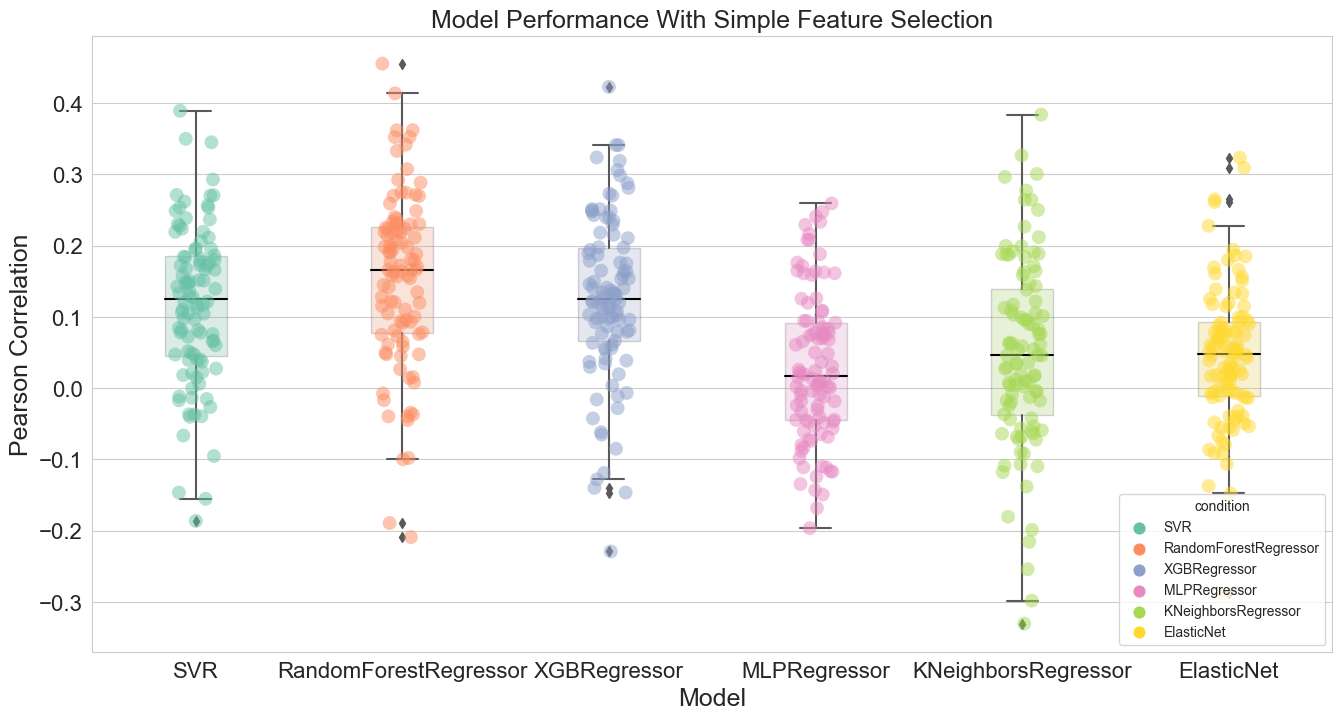

In [7]:
from Visualisation import plot_box_plot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(16, 8))
plot_box_plot(df_all, 'condition', 'model_performance', 'Model Performance With Simple Feature Selection', 'Model'
              ,'Pearson Correlation', ax=ax, tick_fontsize=16)


## Analysis 3 - Ensemble Feature Selection 

In [ ]:
powerkit = Powerkit(feature_data, label_data)
rngs = list(range(100))

all_methods = [f_regression_select, pearson_corr_select, mutual_information_select, relieff_select, rf_select]
all_kwargs = [{}, {'return_all': False}, {}, {}, {'random_state': 42}]
all_ways = ['one_way', 'two_way', 'one_way', 'one_way', 'one_way']
# features, scores = ensemble_percentile_threshold(feature_data, label_data, -1, all_methods, all_kwargs, all_ways)

In [ ]:
pipeline_args = {'all_methods': all_methods, 'all_kwargs': all_kwargs, 'all_ways': all_ways}

def ensemble_pipeline_func(X_train, y_train, rng, model_used, all_methods, all_kwargs, all_ways, **kwargs):
    selected_features, scores = ensemble_percentile_threshold(X_train, y_train, -1, all_methods, all_kwargs, all_ways, n_jobs=4)
    model = get_model_from_string(model_used, **kwargs)
    selected_features, X_selected = select_preset_features(X_train, y_train, selected_features)
    model.fit(X_selected, y_train)
    return {'model': model,
            'filter_selected_features': selected_features,
            'filter_scores': scores}


def eval_func(X_test, y_test, pipeline_components=None, **kwargs):
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp}

In [ ]:
for model_used in all_models:
    powerkit.add_condition(model_used, True, pipeline_func, {'model_used': model_used}, eval_func, {})

In [ ]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, 4, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_ensemble.pkl')

## Analysis 3 - A more efficient implementation

Processes can be made more efficient by pre-computing the ensemble feature selection step. The pre-computed ensemble features from different spliting seeds can then be applied to each model.

Subsequently, the rng seed can be matched later in the training process

### Initial Setup

In [ ]:
# runs feature selection 

powerkit = Powerkit(feature_data, label_data)
rngs = list(range(100))
# lite version 
all_methods = [f_regression_select, pearson_corr_select, mutual_information_select]
all_kwargs = [{}, {'return_all': False}, {}]
all_ways = ['one_way', 'two_way', 'one_way']

### Feature Selection Step

In [ ]:
# import train_test_split
from sklearn.model_selection import train_test_split # type: ignore
import pickle 

feature_selection_data = {}

for i, rng in enumerate(rngs):
    X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1, random_state=rng)
    try: 
        selected_features, scores = ensemble_percentile_threshold(X_train, y_train, -1, all_methods, all_kwargs, all_ways, n_jobs=-1)
        print(f'Finished {i+1} of {len(rngs)}')
        feature_selection_data[rng] = (selected_features, scores)
    except Exception as e:
        print(f'Failed {i+1} of {len(rngs)} with error: {e}')
        continue
    
with open(f'{file_save_path}{exp_id}_ensemble_feature_selection_split_data_100.pkl', 'wb') as f:
    pickle.dump(feature_selection_data, f)
    


### Model Training Step 

In [ ]:
import pickle

# load in the feature selection data
with open(f'{file_save_path}{exp_id}_ensemble_feature_selection_split_data_100.pkl', 'rb') as f:
    feature_selection_data = pickle.load(f)
    
print(f'Size of feature selection data: {len(feature_selection_data)}')

In [ ]:
def ensemble_pipeline_func_pre_compute(X_train, y_train, rng, model_used, feature_selection_data, **kwargs):
    if rng in feature_selection_data:
        selected_features, scores = feature_selection_data[rng]
    else: 
        return {'model': None}
    model = get_model_from_string(model_used, **kwargs)
    selected_features, X_selected = select_preset_features(X_train, y_train, selected_features)
    model.fit(X_selected, y_train)
    return {'model': model,
            'filter_selected_features': selected_features,
            'filter_scores': scores}
    
def eval_func_pre_compute(X_test, y_test, pipeline_components=None, **kwargs):
    if pipeline_components['model'] is None:
        return {'model_performance': 0, 'p_vals': 0, 'feature_importance': 0}
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp}

In [ ]:
for model_used in all_models:
    pipeline_args = {'model_used': model_used, 'feature_selection_data': feature_selection_data}
    powerkit.add_condition(model_used, True, ensemble_pipeline_func_pre_compute, pipeline_args, eval_func_pre_compute, {})

In [ ]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, 16, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_ensemble.pkl')

### Results

In [ ]:
import pickle

df_list = []
for model_used in all_models:
    df = pd.read_pickle(f'{file_save_path}{exp_id}_{model_used}_ensemble.pkl')
    df_list.append(df)

In [ ]:
df_all = pd.concat(df_list, axis=0)
df_all.head()

In [ ]:
# get column with the best model performance

best_model = df_all.groupby('condition')['model_performance'].idxmax()

In [ ]:
best_model

In [ ]:
df_all.iloc[67+100]

## All Results

In [8]:
import pickle
experiments = ['simple', 'control_2', 'ensemble']


df_list_total = []
for exp in experiments:
    df_list = []
    for model_used in all_models:
        df = pd.read_pickle(f'{file_save_path}{exp_id}_{model_used}_{exp}.pkl')
        print(f'Loaded {model_used} for {exp}')
        df_list.append(df)

    # join all the dataframes
    df_all = pd.concat(df_list, axis=0)
    df_all['experiment'] = exp
    df_list_total.append(df_all)

total_df = pd.concat(df_list_total, axis=0)
total_df

Loaded SVR for simple
Loaded RandomForestRegressor for simple
Loaded XGBRegressor for simple
Loaded MLPRegressor for simple
Loaded KNeighborsRegressor for simple
Loaded ElasticNet for simple
Loaded SVR for control_2
Loaded RandomForestRegressor for control_2
Loaded XGBRegressor for control_2
Loaded MLPRegressor for control_2
Loaded KNeighborsRegressor for control_2
Loaded ElasticNet for control_2
Loaded SVR for ensemble
Loaded RandomForestRegressor for ensemble
Loaded XGBRegressor for ensemble
Loaded MLPRegressor for ensemble
Loaded KNeighborsRegressor for ensemble
Loaded ElasticNet for ensemble


,rng,condition,model_performance,p_vals,experiment,feature_importance
0,0,SVR,0.128484,0.300110,simple,NaN
1,1,SVR,0.173691,0.159821,simple,NaN
2,2,SVR,-0.092274,0.457682,simple,NaN
3,3,SVR,0.060600,0.626157,simple,NaN
4,4,SVR,0.031569,0.799801,simple,NaN
...,...,...,...,...,...,...
95,95,ElasticNet,0.081152,0.513861,ensemble,"([aShp2_max, aShp2_tsv, aGAB1_max, aGAB1_tsv, ..."
96,96,ElasticNet,0.056167,0.651661,ensemble,"([amTORC2_tfc, pAkt_tfc, FOXO_tmax, FOXO_tmin,..."
97,97,ElasticNet,0.174051,0.158942,ensemble,"([aShp2_auc, aShp2_max, aShp2_tsv, FOXO_tmax, ..."
98,98,ElasticNet,-0.054089,0.663763,ensemble,"([aGAB1_max, aGAB1_tsv, amTORC2_tfc, aGAB1_auc..."


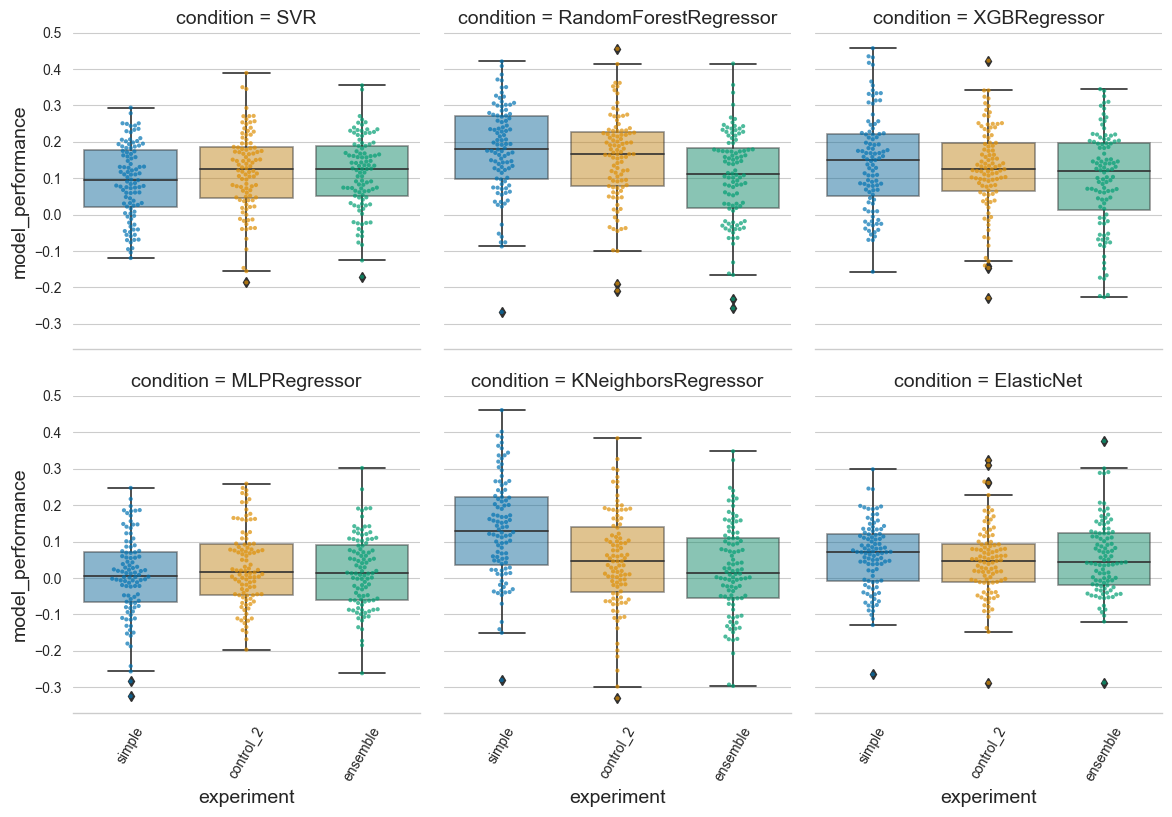

In [9]:
import seaborn as sns
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":14,"axes.labelsize":14, 'xtick.labelsize': 10, 'ytick.labelsize': 10}) 
sns.set_style("whitegrid")
sns.set_palette("colorblind")

g = sns.catplot(
    data=total_df, x="experiment", y="model_performance", col="condition",
    kind="box", height=4, aspect=1, sharey=True, sharex=True, col_wrap=3,
    boxprops=dict(alpha=.5),
)
g.set_xticklabels(rotation=60)
for ax in g.axes.flat:
    # ax.axhline(0, color='black', linestyle='--')
    condition_df = total_df[total_df['condition'] == ax.title.get_text().split('=')[1].strip(' ')]
    # print(ax.title.get_text().split('=')[1].strip(' '))
    sns.swarmplot(data=condition_df, x="experiment", y="model_performance", alpha=0.7, ax=ax, size=3)
    
g.despine(left=True)
plt.show()